In this chapter, we will cover the following recipes:
- Creating custom datasets.
- Defining the model.
- Defining the loss function and optimizer.
- Training the model.
- Deploying the model.

# Creating Custom Datasets

We will use the data from the **Automated measurement of fetal head circumference** competition on the **Grand Challenge** website. During pregnancy, ultrasound imaging is used to measure the fetal head circumference. The measurement can be used to monitor the growth of the fetus. The dataset contains the two-dimensional (2D) ultrasound images of the standard plane.

## Data Exploration

### 1. Let's inspect the training_set folder by counting the number of images and annotations:

In [1]:
import torch

In [2]:
import os
path2train = "./data/training_set/"

imgsList = [pp for pp in os.listdir(path2train) if "Annotation" not in pp]
anntsList = [pp for pp in os.listdir(path2train) if "Annotation" in pp]

print("number of images:", len(imgsList))
print("number of annotation:", len(anntsList))

number of images: 1000
number of annotation: 999


### 2. Next, we will display a few sample images and masks:

In [3]:
import numpy as np
np.random.seed(2019)
rndImgs = np.random.choice(imgsList, 4)
rndImgs

array(['22_HC.png', '498_HC.png', '648_HC.png', '166_2HC.png'],
      dtype='<U11')

In [ ]:
# Define a helper function to show an image and its annotation
import matplotlib.pylab as plt
from PIL import Image
from scipy import ndimage as ndi
from skimage.segmentation import mark_boundaries

def show_img_mask(img, mask):
    """
    Inputs:
        img: A PIL image.
        mask: A PIL or numpy array containing the binary mask
            of the object.
    """
    if torch.is_tensor(img):
        img = to_pil_image(img)
        mask = to_pil_image(mask)
        
    img_mask = mark_boundaries(np.array(img),
                               np.array(mask),
                               outline_color=(0,1,0),
                               color=(0,1,0))
    plt.imshow(img_mask)
    

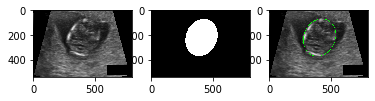

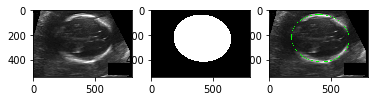

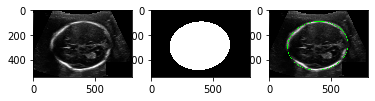

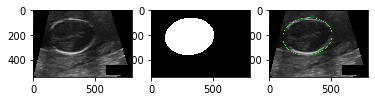

In [4]:
for fn in rndImgs:
    path2img = os.path.join(path2train, fn)
    path2annt = path2img.replace(".png", "_Annotation.png")
    img = Image.open(path2img)
    annt_edges = Image.open(path2annt)
    # Convert edges to binary masks
    mask = ndi.binary_fill_holes(annt_edges)
    
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap="gray")
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    
    plt.subplot(1, 3, 3)
    show_img_mask(img, mask)

## Data augmentation

### 1. Install the albumentations package in your conda environment

### 2. Import the augmentation functions:

In [5]:
from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    Compose,
    Resize)

### 3. Define transform_train for the training dataset:

In [6]:
h, w = 128, 192
transform_train = Compose([Resize(h, w),
                           HorizontalFlip(p=0.5),
                           VerticalFlip(p=0.5),])

### 4. Define transform_val for the validation dataset:

In [7]:
transform_val = Resize(h, w)

## Creating the datasets

### 1. Import the packages and define the dataset class:

In [8]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms.functional import to_tensor, to_pil_image

In [31]:
# Define the fetal_dataset class:
class fetal_dataset(Dataset):
    def __init__(self, path2data, transform=None):
        """
        Input:
            path2data: A string, the location of the data.
            transform: The transformation function.
        """
        imgsList = [pp for pp in os.listdir(path2data) if "Annotation" not in pp]
        anntsList = [pp for pp in os.listdir(path2train) if "Annotation" in pp]
        
        self.path2imgs = [os.path.join(path2data, fn) for fn in imgsList]
        self.path2annts = [p2i.replace(".png", "_Annotation.png") for p2i in self.path2imgs]
        
        self.transform = transform
        
    def __len__(self):
        """
        Returns the length of the dataset.
        """
        return len(self.path2imgs)
    
    def __getitem__(self, idx):
        """
        Loads the image and annotation files and returns the image
        and binary mask.
        """
        path2img = self.path2imgs[idx]
        image = Image.open(path2img)
        
        path2annt = self.path2annts[idx]
        annt_edges = Image.open(path2annt)
        # Convert edges to binary masks
        mask = ndi.binary_fill_holes(annt_edges)
        
        image = np.array(image)
        mask = mask.astype("uint8")
        
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            
        # Convert arrays to PyTorch tensors and normalize them
        # by dividing by 255
        image = to_tensor(image)
        # Scale back mask values to the range of [0, 1]
        mask = 255 * to_tensor(mask)
        
        return image, mask        

### 2. Define two objects of the fetal_dataset class:

In [18]:
fetal_ds1 = fetal_dataset(path2train, transform=transform_train)
fetal_ds2 = fetal_dataset(path2train, transform=transform_val)
print(len(fetal_ds1))
print(len(fetal_ds2))

1000
1000


### 3. Fetch a sample image and mask from the fetal_ds1 and display it:

In [19]:
img, mask = fetal_ds1[1]
print(img.shape, img.type(), torch.max(img))
print(mask.shape, mask.type(), torch.max(mask))

torch.Size([1, 128, 192]) torch.FloatTensor tensor(0.9529)
torch.Size([1, 128, 192]) torch.FloatTensor tensor(1.)


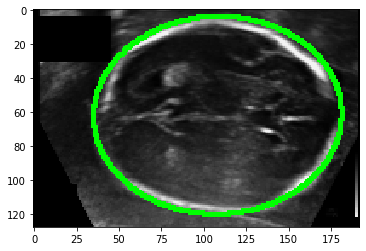

In [20]:
# Display the image and mask
show_img_mask(img, mask)

### 4. Split the data into two groups:

In [21]:
from sklearn.model_selection import ShuffleSplit

sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices = range(len(fetal_ds1))

for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-" * 10)
    print(len(val_index))

800
----------
200


### 5. Create train_ds and val_ds:

In [22]:
from torch.utils.data import Subset

train_ds = Subset(fetal_ds1, train_index)
print(len(train_ds))

val_ds = Subset(fetal_ds2, val_index)
print(len(val_ds))

800
200


### 6. Show a sample image from train_ds:

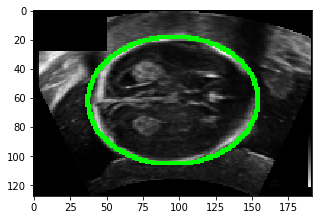

In [23]:
plt.figure(figsize=(5,5))

for img, mask in train_ds:
    show_img_mask(img, mask)
    break

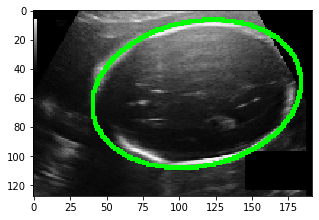

In [24]:
# Show a sample image and mask from val_ds:
plt.figure(figsize=(5,5))
for img, mask in val_ds:
    show_img_mask(img, mask)
    break

### 7. Define the data loaders:

In [25]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)

### 8. Get a sample batch from train_dl:

In [27]:
for img_b, mask_b in train_dl:
    print(img_b.shape, img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break

torch.Size([8, 1, 128, 192]) torch.float32
torch.Size([8, 1, 128, 192]) torch.float32


In [28]:
# Get a sample batch from val_dl
for img_b, mask_b in val_dl:
    print(img_b.shape, img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break

torch.Size([16, 1, 128, 192]) torch.float32
torch.Size([16, 1, 128, 192]) torch.float32


# Defining the model

The popular model architecture for segmentation tasks is the so-called encoder-decoder model.

In the first half of the encoder-decoder model, the input image is downsized to a feature map using a few layers CNNs and pooling layers. In the second half of the model, the feature map is up-sampled to the input image size to produce a binary mask.

The encoder-decoder model was further updated based on the concept of skip-connections from ResNet to another popular architecture called U-Net.

### 1. Let's define the model class. First, import the required packages:

In [32]:
import torch.nn as nn
import torch.nn.functional as F

In [48]:
# Define the SegNet class
class SegNet(nn.Module):
    def __init__(self, params):
        """
        Input:
            params: A Python dictionary containing the model
                    parameters.
                
                input_shape: A tuple, the model input shape
                            (1, height, width)
                initial_filters: An integer, the number of filters
                    in the first CNN layer.
                num_outputs: An integer, the number of output
                    channels; pass 1 for single-object
                    segmentation.
        """
        super(SegNet, self).__init__()
        
        C_in, H_in, W_in = params["input_shape"]
        init_f = params["initial_filters"]
        num_outputs = params["num_outputs"]
        
        # Five CNN blocks for down-sampling
        self.conv1 = nn.Conv2d(C_in, init_f,
                               kernel_size=3,
                               stride=1,padding=1)
        self.conv2 = nn.Conv2d(init_f, 2 * init_f,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.conv3 = nn.Conv2d(2 * init_f, 4 * init_f,
                               kernel_size=3,
                               padding=1)
        self.conv4 = nn.Conv2d(4 * init_f, 8 * init_f,
                               kernel_size=3,
                               padding=1)
        self.conv5 = nn.Conv2d(8 * init_f, 16 * init_f,
                               kernel_size=3,
                               padding=1)
        
        # Up-sampling block
        self.upsample = nn.Upsample(scale_factor=2,
                                    mode='bilinear',
                                    align_corners=True)
        
        # Five CNN blocks for up-sampling the feature map
        self.conv_up1 = nn.Conv2d(16 * init_f,
                                  8 * init_f,
                                  kernel_size=3,
                                  padding=1)
        self.conv_up2 = nn.Conv2d(8 * init_f,
                                  4 * init_f,
                                  kernel_size=3,
                                  padding=1)
        self.conv_up3 = nn.Conv2d(4 * init_f,
                                  2 * init_f,
                                  kernel_size=3,
                                  padding=1)
        self.conv_up4 = nn.Conv2d(2 * init_f,
                                  init_f,
                                  kernel_size=3,
                                  padding=1)
        self.conv_out = nn.Conv2d(init_f, num_outputs,
                                  kernel_size=3,
                                  padding=1)
        
    def forward(self, x):
        """
        Input:
            x: A tensor with a (batch_size, 1, height, width)
                shape.
        """
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv5(x))
        
        x = self.upsample(x)
        x = F.relu(self.conv_up1(x))
        
        x = self.upsample(x)
        x = F.relu(self.conv_up2(x))
        
        x = self.upsample(x)
        x = F.relu(self.conv_up3(x))
        
        x = self.upsample(x)
        x = F.relu(self.conv_up4(x))
        
        x = self.conv_out(x)
        
        return x
        

### 2. Define an object of the SegNet class:

In [44]:
params_model = {
        "input_shape": (1, h, w),
        "initial_filters": 16,
        "num_outputs": 1,}

model = SegNet(params_model)

### 3. Move the model to the GPU device, if available:

In [45]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

### 4. Print the model

In [46]:
print(model)

SegNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample): Upsample(scale_factor=2.0, mode=bilinear)
  (conv_up1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_out): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


### 5. Show the model summary:

In [47]:
from torchsummary import summary

summary(model, input_size=(1, h, w), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 192]             160
            Conv2d-2           [-1, 32, 64, 96]           4,640
            Conv2d-3           [-1, 64, 32, 48]          18,496
            Conv2d-4          [-1, 128, 16, 24]          73,856
            Conv2d-5           [-1, 256, 8, 12]         295,168
          Upsample-6          [-1, 256, 16, 24]               0
            Conv2d-7          [-1, 128, 16, 24]         295,040
          Upsample-8          [-1, 128, 32, 48]               0
            Conv2d-9           [-1, 64, 32, 48]          73,792
         Upsample-10           [-1, 64, 64, 96]               0
           Conv2d-11           [-1, 32, 64, 96]          18,464
         Upsample-12         [-1, 32, 128, 192]               0
           Conv2d-13         [-1, 16, 128, 192]           4,624
           Conv2d-14          [-1, 1, 1

# Defining the loss function and optimizer

The classical loss function for single-object segmentation is the binary corss-entropy (BCE) loss function. The BCE loss function compares each pixel of the prediction with that of the ground truth; however, we can combine multiple criteria to improve the overall performance of segmentation tasks. A popular technique is to combine the dice metric with the BCE loss.

The dice metric is commonly used to test the performance of segmentation algorithms by calculating the amount of overlap between the ground truth and the prediction.

In this section, you will learn how to develop a combined loss function.

### 1. Define a helper function to calculate the dice metric:

In [49]:
def dice_loss(pred, target, smooth=1e-5):
    intersection = (pred * target).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = 2.0 * (intersection + smooth) / (union + smooth)
    loss = 1.0 - dice
    return loss.sum(), dice.sum()

### 2. Define a helper function to calculate the combined loss per data batch:

In [50]:
import torch.nn.functional as F

def loss_func(pred, target):
    bce = F.binary_cross_entropy_with_logits(pred, target,
                                             reduction='sum')
    pred = torch.sigmoid(pred)
    dlv, _ = dice_loss(pred, target)
    loss = bce + dlv
    
    return loss

### 3. Define the metrics_batch helper function:

In [51]:
def metrics_batch(pred, target):
    pred = torch.sigmoid(pred)
    _, metric = dice_loss(pred, target)
    return metric

### 4. Let's define the loss_batch helper function:

In [52]:
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    _, metric_b = dice_loss(pred, target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    return loss.item(), metric_b

### 5. Let's define the loss_batch